⚡ Using Apple MPS (Metal GPU) backend
📂 Train samples: 5710 | Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
📂 Test samples : 1309 | Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
🚀 Using VGG16 Pretrained Backbone


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/muhammadmuhtasimshahriar/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [01:32<00:00, 6.00MB/s] 

🚀 Training VGG16...
[Epoch 01] LR=1.00e-05 | Train Acc=0.7720, Test Acc=0.8518 | Train Loss=0.7841, Test Loss=0.6295 | Test F1=0.8476
💾 New Best Model: F1=0.8476 at Epoch 1
[Epoch 02] LR=1.00e-05 | Train Acc=0.9126, Test Acc=0.8885 | Train Loss=0.5541, Test Loss=0.5519 | Test F1=0.8849
💾 New Best Model: F1=0.8849 at Epoch 2
[Epoch 03] LR=1.00e-05 | Train Acc=0.9273, Test Acc=0.9190 | Train Loss=0.5016, Test Loss=0.5121 | Test F1=0.9168
💾 New Best Model: F1=0.9168 at Epoch 3
[Epoch 04] LR=1.00e-05 | Train Acc=0.9457, Test Acc=0.9442 | Train Loss=0.4658, Test Loss=0.4712 | Test F1=0.9424
💾 New Best Model: F1=0.9424 at Epoch 4
[Epoch 05] LR=1.00e-05 | Train Acc=0.9608, Test Acc=0.9481 | Train Loss=0.4444, Test Loss=0.4542 | Test F1=0.9465
💾 New Best Model: F1=0.9465 at Epoch 5
[Epoch 06] LR=1.00e-05 | Train Acc=0.9692, Test Acc=0.9519 | Train Loss=0.4238, Test Loss=0.4430 | Test F1=0.9505
💾 New Best Model: F1=0.9505 at Epoch 6
[Epoch 07

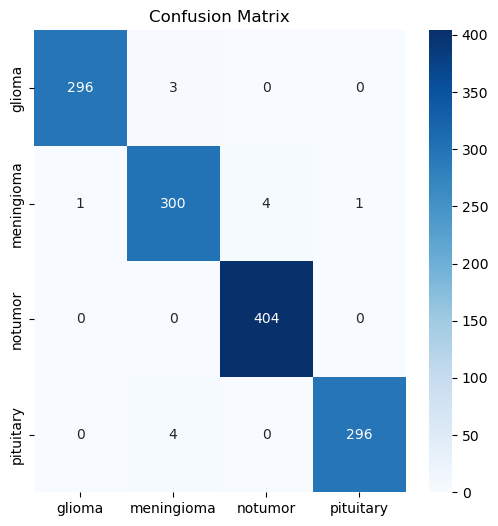

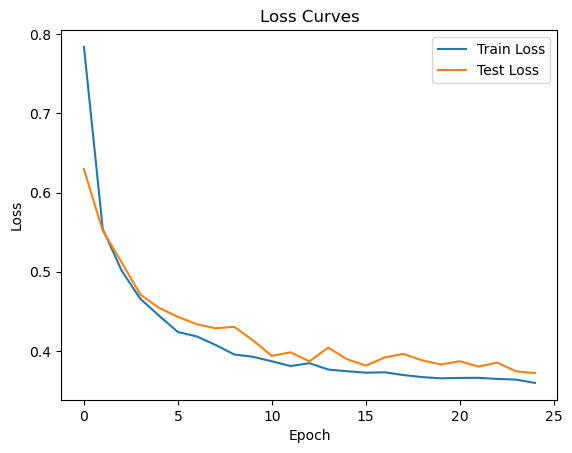

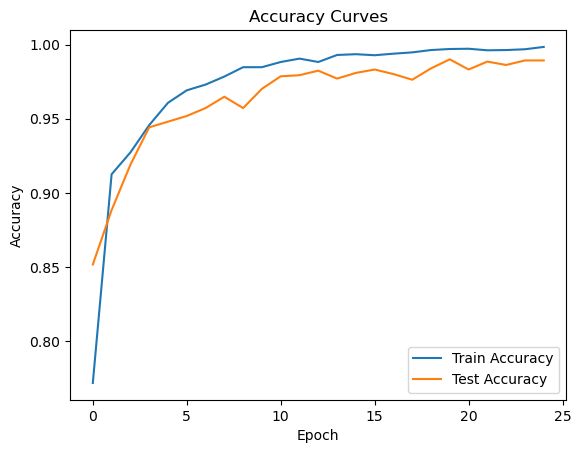

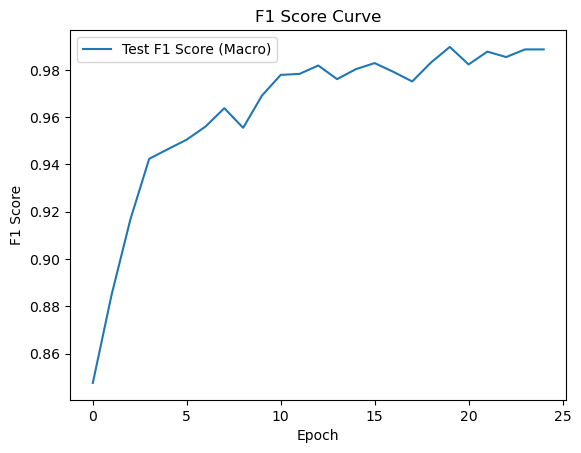

In [1]:
import os, time, warnings, logging
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =====================
# SETTINGS
# =====================
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

# Use MPS (Apple GPU) if available
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    logger.info("⚡ Using Apple MPS (Metal GPU) backend")
else:
    DEVICE = torch.device("cpu")
    logger.info("⚠️ MPS not available, using CPU")

BATCH_SIZE = 16
EPOCHS = 30
IMG_SIZE = 224   # VGG16 default
LR = 1e-5
PATIENCE = 5     # early stopping

TRAIN_DIR = r'/Users/muhammadmuhtasimshahriar/Downloads/archive/Training'
TEST_DIR  = r'/Users/muhammadmuhtasimshahriar/Downloads/archive/Testing'

# =====================
# DATA TRANSFORMS
# =====================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =====================
# DATASETS & CLASSES
# =====================
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=test_transform)

logger.info(f"📂 Train samples: {len(train_dataset)} | Classes: {train_dataset.classes}")
logger.info(f"📂 Test samples : {len(test_dataset)} | Classes: {test_dataset.classes}")

num_classes = len(train_dataset.classes)

# =====================
# BALANCED SAMPLER
# =====================
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / class_counts
samples_weight = [class_weights[t] for t in train_dataset.targets]
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# =====================
# MODEL: VGG16
# =====================
logger.info("🚀 Using VGG16 Pretrained Backbone")
model = models.vgg16(weights="IMAGENET1K_V1")
in_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features, num_classes)

# Fine-tune all layers
for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.3)

model = model.to(DEVICE)

# =====================
# TRAINING
# =====================
best_f1, patience_counter, best_epoch = 0, 0, 0
train_acc_list, test_acc_list = [], []
train_loss_list, test_loss_list, f1_list = [], [], []

start_time = time.time()
logger.info("\n🚀 Training VGG16...")

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = total_loss / len(train_loader)

    # ---- Eval ----
    model.eval()
    y_true, y_pred = [], []
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    test_loss /= len(test_loader)
    test_f1 = f1_score(y_true, y_pred, average="macro")

    # Record
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    f1_list.append(test_f1)

    scheduler.step(test_f1)
    lr = optimizer.param_groups[0]['lr']

    logger.info(f"[Epoch {epoch+1:02d}] LR={lr:.2e} | "
                f"Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f} | "
                f"Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f} | "
                f"Test F1={test_f1:.4f}")

    # Save best
    if test_f1 > best_f1:
        best_f1 = test_f1
        best_epoch = epoch+1
        patience_counter = 0
        torch.save(model.state_dict(), "best_vgg16.pth")
        logger.info(f"💾 New Best Model: F1={best_f1:.4f} at Epoch {best_epoch}")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            logger.info("⏹ Early stopping.")
            break

elapsed = (time.time()-start_time)/60
logger.info(f"\n⏱ Training finished in {elapsed:.1f} min. Best F1={best_f1:.4f} at epoch {best_epoch}")

# =====================
# LOAD BEST MODEL
# =====================
model.load_state_dict(torch.load("best_vgg16.pth"))
model.eval()
logger.info("🔄 Loaded best saved VGG16 for final evaluation.")

# =====================
# FINAL EVALUATION
# =====================
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

final_acc = accuracy_score(y_true, y_pred)
final_prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
final_rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
final_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

logger.info("\n📊 FINAL PERFORMANCE SUMMARY")
logger.info("===================================")
logger.info(f"✅ Accuracy         : {final_acc*100:.2f}%")
logger.info(f"🎯 Precision (Macro): {final_prec:.4f}")
logger.info(f"📌 Recall    (Macro): {final_rec:.4f}")
logger.info(f"📈 F1-Score  (Macro): {final_f1:.4f}")

# =====================
# CONFUSION MATRIX
# =====================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# =====================
# TRAINING CURVES
# =====================
plt.figure()
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(f1_list, label="Test F1 Score (Macro)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score Curve")
plt.legend()
plt.show()